In [2]:
""" 
04 MARCH 2024 
Theo Gauvrit
Testing the higher baseline hypothesis to explain the no detection of tactile stimulus on KO mice.
"""

import numpy as np
import pandas as pd
import percephone.core.recording as pc
import os
import percephone.plts.behavior as pbh
import matplotlib
import percephone.plts.stats as ppt
import matplotlib.pyplot as plt
import percephone.analysis.mlr_models as mlr_m
from multiprocessing import Pool, cpu_count, pool
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 2
plt.switch_backend("Qt5Agg")
matplotlib.use("Qt5Agg")
%matplotlib inline

In [3]:
user = "Célien"

if user == "Célien":
    directory = "C:/Users/cvandromme/Desktop/Data/"
    roi_path = "C:/Users/cvandromme/Desktop/FmKO_ROIs&inhibitory.xlsx"
elif user == "Théo":
    directory = "/datas/Théo/Projects/Percephone/data/Amplitude_Detection/loop_format_tau_02/"
    roi_path = directory + "/FmKO_ROIs&inhibitory.xlsx"
    
roi_info = pd.read_excel(roi_path)
files = os.listdir(directory)
files_ = [file for file in files if file.endswith("synchro")]

def opening_rec(fil, i):
    rec = pc.RecordingAmplDet(directory + fil + "/", 0, roi_path)
    return rec

workers = cpu_count()
if user == "Célien":
    pool = pool.ThreadPool(processes=workers)
elif user == "Théo":
    pool = Pool(processes=workers)
async_results = [pool.apply_async(opening_rec, args=(file, i)) for i, file in enumerate(files_)]
recs = {ar.get().filename: ar.get() for ar in async_results}

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorpor

## Comparison between baseline before detected stimulus and baseline before undetected stimulus in the same animal

Testing if the mean baseline before the stimulus detected and non detected is different in all the neurons of the two different group of mice.

MLR model already computed
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9902738433290044, pvalue=0.6996604380711142)
ShapiroResult(statistic=0.9098671617519316, pvalue=5.162847951189783e-06)
WilcoxonResult(statistic=1001.0, pvalue=4.468672015396775e-07)
MLR model already computed
Boxplot plotting.
---  mean baseline ---
ShapiroResult(statistic=0.9468413453385593, pvalue=7.972523425802156e-05)
ShapiroResult(statistic=0.9858977700335735, pvalue=0.213616810360181)
WilcoxonResult(statistic=3056.0, pvalue=0.015290153015004849)
MLR model already computed
Boxplot plotting.
---  mean baseline ---
ShapiroResult(statistic=0.9689495648640909, pvalue=0.005618790254266999)
ShapiroResult(statistic=0.8134565636113951, pvalue=2.669188310497021e-11)
WilcoxonResult(statistic=1498.0, pvalue=1.8465692838910314e-09)
MLR model already computed
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9311322046129306, pvalue=4.840948870547932e-06)
ShapiroResult(statistic=0.98558

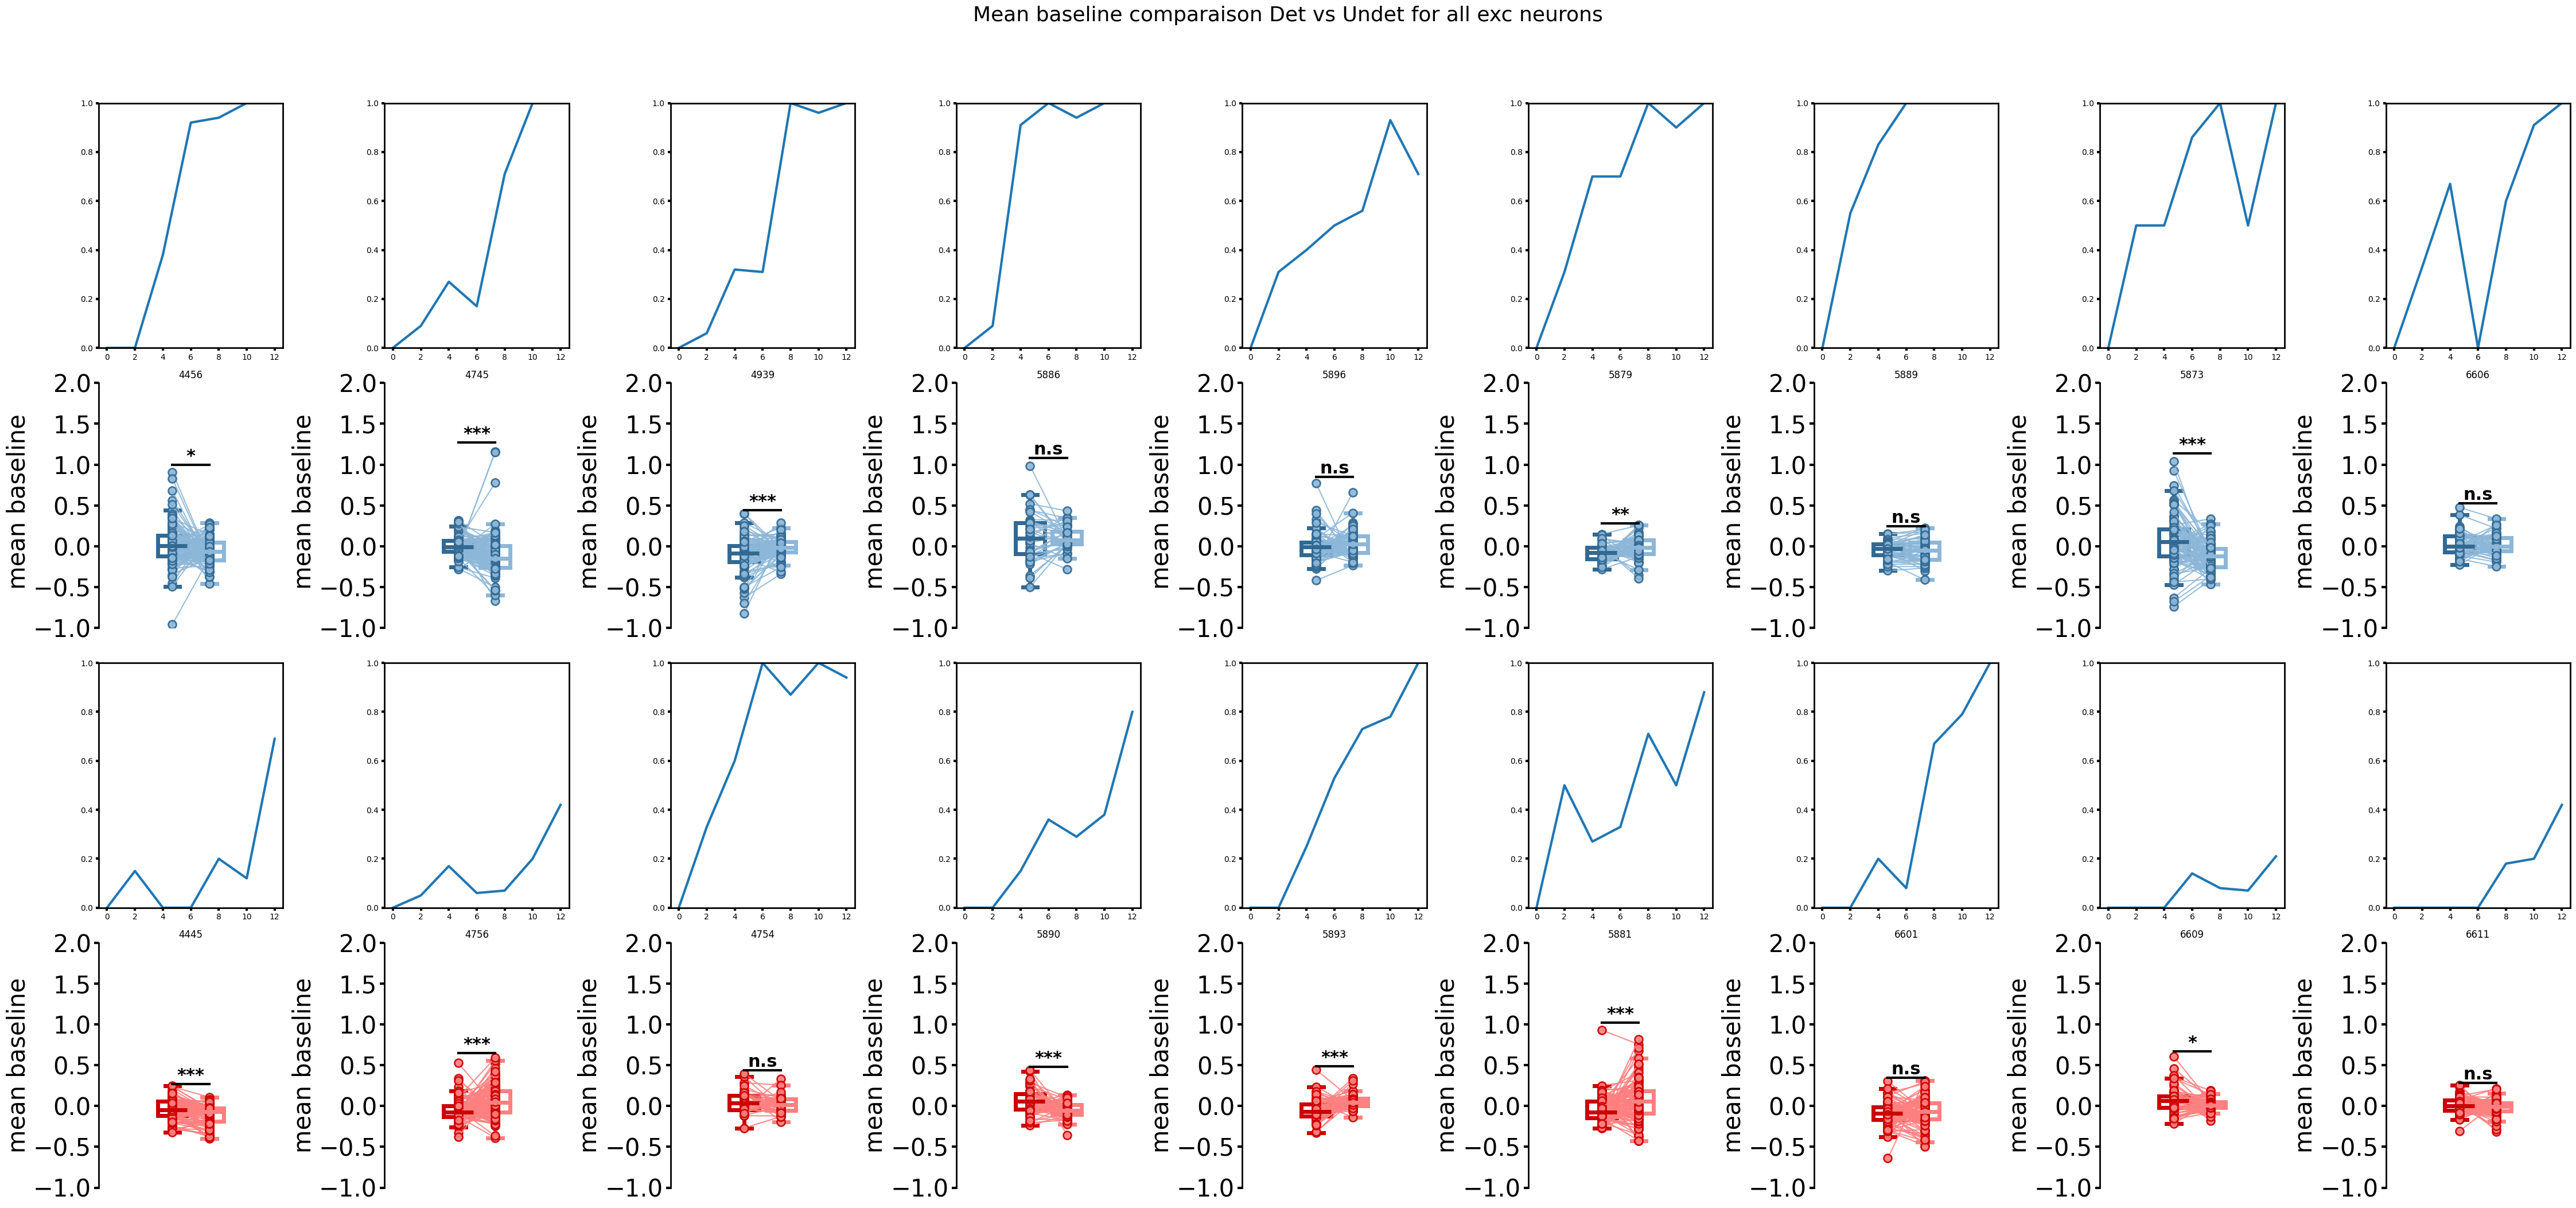

In [8]:
y, i = 0, 0
fig, ax = plt.subplots(4, 9, figsize=(45, 20))

for rec in recs.values():
        mlr_model, model_name = mlr_m.precise_stim_model(rec)
        rec.mlr(mlr_model, model_name)
        trace = rec.zscore_exc 
        #  get all the bsl before stim of the corresponding amp stim
        stims_det = rec.stim_time[rec.detected_stim & (rec.stim_ampl ==rec.threshold)]
        bsl = trace[:, np.linspace(stims_det - int(1 * rec.sf), stims_det, int(1 * rec.sf), dtype=int)]
        bsl_ = bsl.reshape(len(trace), len(stims_det) * int(1 * rec.sf))
        det_bsl = np.mean(bsl_, axis=1)
        stims_undet = rec.stim_time[~rec.detected_stim & (rec.stim_ampl == rec.threshold)]
        bsl = trace[:, np.linspace(stims_undet - int(1 * rec.sf), stims_undet, int(1 * rec.sf), dtype=int)]
        bsl_ = bsl.reshape(len(trace), len(stims_undet) * int(1 * rec.sf))
        undet_bsl = np.mean(bsl_, axis=1)
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            ppt.paired_boxplot(ax[1, i], det_bsl, undet_bsl, " mean baseline", rec.filename,colors=[ppt.wt_color, ppt.light_wt_color], ylim=[-1,2])
            i = i + 1
        else:
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            ppt.paired_boxplot(ax[3, y], det_bsl, undet_bsl, "mean baseline", rec.filename, ylim=[-1,2])
            y = y + 1

# ax[2, 6].set_axis_off()
# ax[2, 7].set_axis_off()
# ax[3, 6].set_axis_off()
# ax[3, 7].set_axis_off()
fig.suptitle('Mean baseline comparaison Det vs Undet for all exc neurons', y=1.05,fontsize=26)
fig.tight_layout()

In this figure the baseline before the detected stimulus (1st boxplot) is compared to the baseline before the undetected stimulus for all the different recording. The amplitude of the stimulus that is chosen for each comparison is manual defined from the observation of the psychometric curve plotted above the boxplots, it should have enough detected and undetected trials to be able to do the comparison. WT mice are on the first line and KO mice are on the second line.
We can observe that the baseline is significantly higher for 4 of 6 of the KO mice and 5 out of 7 WT mice. It seems that could be an explanation of the failed detection for both genotype.

If we choose the standard deviation instead of the mean to calculate the comparison of the baseline activity: 

In [ ]:
y, i = 0, 0
amps = [2, 6, 4, 4, 4, 8, 4, 4, 12, 8, 6, 12, 12]  # manual selection of the threshold amp for each animal from psychometric curves
fig, ax = plt.subplots(4, 8, figsize=(40, 20))

for rec in recs:
        mlr_model, model_name = mlr_m.precise_stim_model(rec)
        rec.mlr(mlr_model, model_name)
        trace = rec.zscore_exc 
        #  get all the bsl before stim of the corresponding amp stim
        stims_det = rec.stim_time[rec.detected_stim & (rec.stim_ampl == rec.threshold)]
        bsl = trace[:, np.linspace(stims_det - int(1 * rec.sf), stims_det, int(1 * rec.sf), dtype=int)]
        bsl_ = bsl.reshape(len(trace), len(stims_det) * int(1 * rec.sf))
        det_bsl = np.std(bsl_, axis=1)
        stims_undet = rec.stim_time[~rec.detected_stim & (rec.stim_ampl == rec.threshold)]
        bsl = trace[:, np.linspace(stims_undet - int(1 * rec.sf), stims_undet, int(1 * rec.sf), dtype=int)]
        bsl_ = bsl.reshape(len(trace), len(stims_undet) * int(1 * rec.sf))
        undet_bsl = np.std(bsl_, axis=1)
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            ppt.paired_boxplot(ax[1, i], det_bsl, undet_bsl, " std baseline", " ",colors=[ppt.wt_color, ppt.light_wt_color],ylim=[0,3])
            i = i + 1
        else:
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            ppt.paired_boxplot(ax[3, y], det_bsl, undet_bsl, "std baseline", " ",ylim=[0,3])
            y = y + 1

ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Std baseline comparaison Det vs Undet for all exc neurons', y=1.05, fontsize=26)
fig.tight_layout()

The comparisons of the standard deviation of the baseline for KO group are still the same but for the WT group only 3 out of 7 are still significant

The next step is to compare only the neurons that were found significant with the MLR analysis, maybe the neurons silent or non-responding parasite the comparison of the baseline. We test here for all MLR neurons independently of their mlr labels

In [ ]:
y, i = 0, 0
amps = [2, 6, 4, 4, 4, 8, 4, 4, 12, 8, 6, 12, 12]  # manual selection of the threshold amp for each animal from psychometric curves
fig, ax = plt.subplots(4, 8, figsize=(40, 20))

for rec in recs:
        mlr_model, model_name = mlr_m.precise_stim_model(rec)
        rec.mlr(mlr_model, model_name)
        trace = rec.zscore_exc[rec.mlr_labels_exc["indices_r2"]] # we select only neurons with a significant r2
        #  get all the bsl before stim of the corresponding amp stim
        stims_det = rec.stim_time[rec.detected_stim & (rec.stim_ampl == rec.threshold)]
        bsl = trace[:, np.linspace(stims_det - int(1 * rec.sf), stims_det, int(1 * rec.sf), dtype=int)]
        bsl_ = bsl.reshape(len(trace), len(stims_det) * int(1 * rec.sf))
        det_bsl = np.mean(bsl_, axis=1)
        stims_undet = rec.stim_time[~rec.detected_stim & (rec.stim_ampl == rec.threshold)]
        bsl = trace[:, np.linspace(stims_undet - int(1 * rec.sf), stims_undet, int(1 * rec.sf), dtype=int)]
        bsl_ = bsl.reshape(len(trace), len(stims_undet) * int(1 * rec.sf))
        undet_bsl = np.mean(bsl_, axis=1)
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            ppt.paired_boxplot(ax[1, i], det_bsl, undet_bsl, "mean baseline","",colors=[ppt.wt_color, ppt.light_wt_color], ylim=[-1,2])
            i = i + 1
        else:
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            ppt.paired_boxplot(ax[3, y], det_bsl, undet_bsl, "mean baseline","", ylim=[-1,2])
            y = y + 1

ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Mean baseline comparaison Det vs Undet for MLR significant exc neurons', y=1.05, fontsize=26)
fig.tight_layout()

The global trend seems to be the same in KO mice but lot less significant animals. The result is opposite of what we hypothesised before. It seems even that in WT group the dynamic is opposite, the firing neurons have lower baseline in non detected stimulus. Similar analysis should be made with a discrimination of the  clusters of neurons 



Testing with all inhibitory cells

In [ ]:
y, i = 0, 0
amps = [2, 6, 4, 4, 4, 8, 4, 4, 12, 8, 6, 12, 12]  # manual selection of the threshold amp for each animal from psychometric curves
fig, ax = plt.subplots(4, 8, figsize=(40, 20))

for rec in recs:
        mlr_model, model_name = mlr_m.precise_stim_model(rec)
        rec.mlr(mlr_model, model_name)
        trace = rec.zscore_inh
        #  get all the bsl before stim of the corresponding amp stim
        stims_det = rec.stim_time[rec.detected_stim & (rec.stim_ampl == rec.threshold)]
        bsl = trace[:, np.linspace(stims_det - int(1 * rec.sf), stims_det, int(1 * rec.sf), dtype=int)]
        bsl_ = bsl.reshape(len(trace), len(stims_det) * int(1 * rec.sf))
        det_bsl = np.mean(bsl_, axis=1)
        stims_undet = rec.stim_time[~rec.detected_stim & (rec.stim_ampl == rec.threshold)]
        bsl = trace[:, np.linspace(stims_undet - int(1 * rec.sf), stims_undet, int(1 * rec.sf), dtype=int)]
        bsl_ = bsl.reshape(len(trace), len(stims_undet) * int(1 * rec.sf))
        undet_bsl = np.mean(bsl_, axis=1)
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            ppt.paired_boxplot(ax[1, i], det_bsl, undet_bsl, " mean baseline", " ",colors=[ppt.wt_color, ppt.light_wt_color],  ylim= [-1,2])
            i = i + 1
        else:
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            ppt.paired_boxplot(ax[3, y], det_bsl, undet_bsl, "mean baseline", " ", ylim= [-1,2])
            y = y + 1

ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Mean baseline comparaison Det vs Undet for all inhibitory neurons', y=1.05, fontsize=26)
fig.tight_layout()

Comparison of baseline for all exc neurons in between when it is activated and when it is inhibited

In [ ]:
y, i = 0, 0
amps = [2, 6, 4, 4, 4, 8, 4, 4, 12, 8, 6, 12, 12]  # manual selection of the threshold amp for each animal from psychometric curves
fig, ax = plt.subplots(4, 8, figsize=(40, 20))

for rec  in recs:
        # rec.responsivity()
        trace = rec.zscore_exc
        #  get all the bsl before stim of the corresponding amp stim
        act_bsl = []
        nact_bsl = []
        for idx, n_df in enumerate(trace):
            resp_n = np.array(rec.matrices["EXC"]["Responsivity"][idx])
            act_bsl_n = n_df[np.linspace(rec.stim_time[resp_n == 1 ] - int(1 * rec.sf), rec.stim_time[resp_n == 1 ], int(1 * rec.sf), dtype=int)]
            nact_bsl_n = n_df[np.linspace(rec.stim_time[resp_n == -1] - int(1 * rec.sf), rec.stim_time[resp_n == -1], int(1 * rec.sf), dtype=int)]
            if np.count_nonzero(~np.isnan(act_bsl_n)) > 3 and np.count_nonzero(~np.isnan(nact_bsl_n))> 3:
                act_bsl.append(np.mean(act_bsl_n[~np.isnan(act_bsl_n)]))
                nact_bsl.append(np.mean(nact_bsl_n[~np.isnan(nact_bsl_n)]))
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            ppt.paired_boxplot(ax[1, i], np.array(act_bsl), np.array(nact_bsl), "mean baseline","",colors=[ppt.wt_color, ppt.light_wt_color],ylim=[-1,6])
            i = i + 1
        else:
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            ppt.paired_boxplot(ax[3, y], np.array(act_bsl), np.array(nact_bsl), "mean baseline","",ylim=[-1,6])

            y = y + 1

ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Mean baseline comparison active vs inhibited for all exc neurons', y=1.05, fontsize=26)
fig.tight_layout()

In [ ]:
y, i = 0, 0
amps = [2, 6, 4, 4, 4, 8, 4, 4, 12, 8, 6, 12, 12]  # manual selection of the threshold amp for each animal from psychometric curves
fig, ax = plt.subplots(4, 8, figsize=(40, 20))

for rec in recs:
        # rec.responsivity()
        trace = rec.zscore_exc
        #  get all the bsl before stim of the corresponding amp stim
        act_bsl = []
        nact_bsl = []
        for idx, n_df in enumerate(trace):
            resp_n = np.array(rec.matrices["EXC"]["Responsivity"][idx])
            act_bsl_n = n_df[np.linspace(rec.stim_time[resp_n == 0] - int(1 * rec.sf), rec.stim_time[resp_n == 0], int(1 * rec.sf), dtype=int)]
            nact_bsl_n = n_df[np.linspace(rec.stim_time[resp_n == -1] - int(1 * rec.sf), rec.stim_time[resp_n == -1], int(1 * rec.sf), dtype=int)]
            if np.count_nonzero(~np.isnan(act_bsl_n)) > 3 and np.count_nonzero(~np.isnan(nact_bsl_n))> 3:
                act_bsl.append(np.mean(act_bsl_n[~np.isnan(act_bsl_n)]))
                nact_bsl.append(np.mean(nact_bsl_n[~np.isnan(nact_bsl_n)]))
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            ppt.paired_boxplot(ax[1, i], np.array(act_bsl), np.array(nact_bsl), "mean baseline","",colors=[ppt.wt_color, ppt.light_wt_color], ylim=[-1,8])
            i = i + 1
        else:
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            ppt.paired_boxplot(ax[3, y], np.array(act_bsl), np.array(nact_bsl), "mean baseline","", ylim=[-1,8])
            y = y + 1

ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Mean baseline comparison non-activated vs inhibited for all exc neurons', y=1.05, fontsize=26)
fig.tight_layout()

In [ ]:
y, i = 0, 0
amps = [2, 6, 4, 4, 4, 8, 4, 4, 12, 8, 6, 12, 12]  # manual selection of the threshold amp for each animal from psychometric curves
fig, ax = plt.subplots(4, 8, figsize=(40, 20))

for rec in recs:
        # rec.responsivity()
        trace = rec.zscore_exc
        #  get all the bsl before stim of the corresponding amp stim
        act_bsl = []
        nact_bsl = []
        for idx, n_df in enumerate(trace):
            resp_n = np.array(rec.matrices["EXC"]["Responsivity"][idx])
            act_bsl_n = n_df[np.linspace(rec.stim_time[resp_n == 0] - int(1 * rec.sf), rec.stim_time[resp_n == 0], int(1 * rec.sf), dtype=int)]
            nact_bsl_n = n_df[np.linspace(rec.stim_time[resp_n == 1] - int(1 * rec.sf), rec.stim_time[resp_n == 1], int(1 * rec.sf), dtype=int)]
            if np.count_nonzero(~np.isnan(act_bsl_n)) > 3 and np.count_nonzero(~np.isnan(nact_bsl_n))> 3:
                act_bsl.append(np.mean(act_bsl_n[~np.isnan(act_bsl_n)]))
                nact_bsl.append(np.mean(nact_bsl_n[~np.isnan(nact_bsl_n)]))
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            ppt.paired_boxplot(ax[1, i], np.array(act_bsl), np.array(nact_bsl), "mean baseline","",colors=[ppt.wt_color, ppt.light_wt_color], ylim = [-1,6])
            i = i + 1
        else:
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            ppt.paired_boxplot(ax[3, y], np.array(act_bsl), np.array(nact_bsl), "mean baseline","", ylim = [-1,6])
            y = y + 1

ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Mean baseline comparison non-activated vs activated for all exc neurons', y=1.05, fontsize=26)
fig.tight_layout()

non-activated versus inhibited

In [ ]:
y, i = 0, 0
fig, ax = plt.subplots(4, 8, figsize=(40, 20))

for rec in recs:
        # rec.responsivity()
        trace = rec.zscore_exc
        #  get all the bsl before stim of the corresponding amp stim
        act_bsl = []
        nact_bsl = []
        for idx, n_df in enumerate(trace):
            resp_n = np.array(rec.matrices["EXC"]["Responsivity"][idx])
            act_bsl_n = n_df[np.linspace(rec.stim_time[resp_n == 0] - int(1 * rec.sf), rec.stim_time[resp_n == 0], int(1 * rec.sf), dtype=int)]
            nact_bsl_n = n_df[np.linspace(rec.stim_time[resp_n == -1] - int(1 * rec.sf), rec.stim_time[resp_n == -1], int(1 * rec.sf), dtype=int)]
            if np.count_nonzero(~np.isnan(act_bsl_n)) > 3 and np.count_nonzero(~np.isnan(nact_bsl_n))> 3:
                act_bsl.append(np.mean(act_bsl_n[~np.isnan(act_bsl_n)]))
                nact_bsl.append(np.mean(nact_bsl_n[~np.isnan(nact_bsl_n)]))
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            ppt.paired_boxplot(ax[1, i], np.array(act_bsl), np.array(nact_bsl), " mean baseline", "" ,colors=[ppt.wt_color, ppt.light_wt_color], ylim = [-1,8])
            i = i + 1
        else:
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            ppt.paired_boxplot(ax[3, y], np.array(act_bsl), np.array(nact_bsl), "mean baseline", "", ylim = [-1,8])
            y = y + 1

ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Mean baseline comparison non-activated vs inhibited for all exc neurons', y=1.05, fontsize=26)
fig.tight_layout()

Check if there is differences of cross correlation in the baseline activity before the stim 

In [ ]:
y, i = 0, 0
amps = [2, 6, 4, 4, 4, 8, 4, 4, 12, 8, 6, 12, 12]  # manual selection of the threshold amp for each animal from psychometric curves
fig, ax = plt.subplots(4, 8, figsize=(40, 20))

for rec in recs:
        # mlr_model, model_name = mlr_m.precise_stim_model(rec)
        # rec.mlr(mlr_model, model_name)
        #index of acviated neurons
        # rec.responsivity()
        resp_mat = np.array(rec.matrices["EXC"]["Responsivity"])
        resp_mat[resp_mat!=1]=0
        idx_responsive = np.where(np.count_nonzero(resp_mat,axis=1) > 15)[0]
        if len(idx_responsive)<3:
            continue
        trace = rec.df_f_exc[idx_responsive]
        #  get all the bsl before stim of the corresponding amp stim
        stims_det = rec.stim_time[rec.detected_stim]
        pre_stim_d = 3
        bsl = trace[:, np.linspace(stims_det - int(pre_stim_d * rec.sf), stims_det, int(pre_stim_d * rec.sf), dtype=int)]
        bsl_ = bsl.reshape(len(trace), len(stims_det) * int(pre_stim_d* rec.sf))
        det_bsl = np.std(bsl_, axis=1)
        stims_undet = rec.stim_time[~rec.detected_stim]
        bsl = trace[:, np.linspace(stims_undet - int(pre_stim_d * rec.sf), stims_undet, int(pre_stim_d  * rec.sf), dtype=int)]
        bsl_ = bsl.reshape(len(trace), len(stims_undet) * int(pre_stim_d * rec.sf))
        undet_bsl = np.std(bsl_, axis=1)
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            ppt.paired_boxplot(ax[1, i], det_bsl, undet_bsl, " mean baseline", "AMP: " + str(rec.threshold) + " " + str(rec.filename),ylim=[])
            i = i + 1
        else:
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            ppt.paired_boxplot(ax[3, y], det_bsl, undet_bsl, "mean baseline", "AMP: " + str(rec.threshold) + " " + str(rec.filename),ylim=[])
            y = y + 1

ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Mean baseline comparaison Det vs Undet for all exc neurons', fontsize=26)